In [1]:
!pip install segmentation-models
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires di

In [2]:
import sys
sys.path.append('/kaggle/input/helper-scripts')

In [3]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from fetch_data import fetch
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from visualise import visualize, denormalize

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [4]:
base_dir = '/kaggle/input/isic-2016/ISIC 2016 for segmentation/ISIC 2016 for segmentation/'
batch_size = 4 
input_size = (224, 224)
num_epochs = 40
shuffle = True
ratio = 1
grp = 0
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model_save = '2016_original_best_model.h5'

callbacks = [ModelCheckpoint('./'+model_save, 
                             monitor = "val_iou_score",
                             save_weights_only=True, 
                             save_best_only=True, 
                             mode='max',
                             initial_value_threshold = 0.0),
            ReduceLROnPlateau(monitor = "val_iou_score",
                             factor = 0.2,
                             patience = 3,
                             verbose = 1,
                             mode = 'max')]

In [5]:
train_dataset, validation_dataset = fetch(base_dir, input_size, grp, batch_size, shuffle, ratio)

train_images:  /kaggle/input/isic-2016/ISIC 2016 for segmentation/ISIC 2016 for segmentation/Train/IMAGES/
no. of training images:  900
train_masks:  /kaggle/input/isic-2016/ISIC 2016 for segmentation/ISIC 2016 for segmentation/Train/MASKS/
no. of training masks:  900
test_images:  /kaggle/input/isic-2016/ISIC 2016 for segmentation/ISIC 2016 for segmentation/Test/IMAGES/
no. of test images:  379
test_masks:  /kaggle/input/isic-2016/ISIC 2016 for segmentation/ISIC 2016 for segmentation/Test/MASKS/
no. of test masks:  379


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [6]:
model = sm.Unet(backbone_name = "densenet201",
                   input_shape=(224, 224, 3))

model.compile(optimizer=Adam(learning_rate = 4e-6), 
              loss=sm.losses.bce_dice_loss, 
              metrics=metrics)

print(len(model.layers))
model.summary()

74836368/74836368 [==============================] - 2s 0us/step
748
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                         

In [7]:
history = model.fit(train_dataset, epochs=num_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/40
225/225 [==============================] - 616s 3s/step - loss: 1.1613 - iou_score: 0.3412 - f1-score: 0.4987 - val_loss: 1.1913 - val_iou_score: 0.2961 - val_f1-score: 0.4302 - lr: 4.0000e-06
Epoch 2/40
225/225 [==============================] - 601s 3s/step - loss: 0.9006 - iou_score: 0.5502 - f1-score: 0.7042 - val_loss: 1.0098 - val_iou_score: 0.4179 - val_f1-score: 0.5498 - lr: 4.0000e-06
Epoch 3/40
225/225 [==============================] - 603s 3s/step - loss: 0.7737 - iou_score: 0.6375 - f1-score: 0.7736 - val_loss: 0.8168 - val_iou_score: 0.5844 - val_f1-score: 0.7060 - lr: 4.0000e-06
Epoch 4/40
225/225 [==============================] - 602s 3s/step - loss: 0.7087 - iou_score: 0.6753 - f1-score: 0.8005 - val_loss: 0.7046 - val_iou_score: 0.6721 - val_f1-score: 0.7799 - lr: 4.0000e-06
Epoch 5/40
225/225 [==============================] - 602s 3s/step - loss: 0.6598 - iou_score: 0.6967 - f1-score: 0.8145 - val_loss: 0.6608 - val_iou_score: 0.7020 - val_f1-score: 0.80

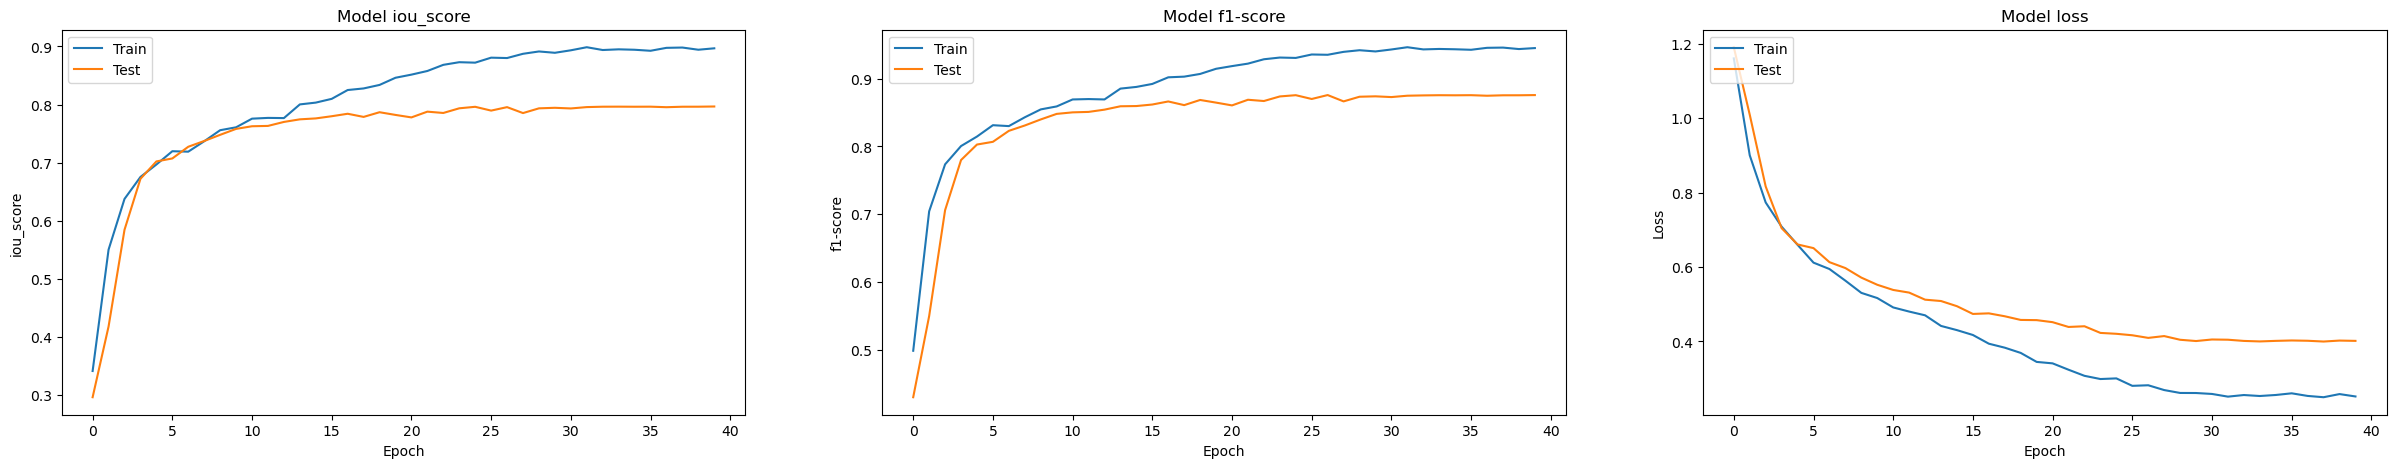

In [8]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation iou_score values
plt.subplot(132)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
model.load_weights(model_save) 

In [10]:
scores = model.evaluate(validation_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

379/379 [==============================] - 131s 335ms/step - loss: 0.4014 - iou_score: 0.7966 - f1-score: 0.8757
Loss: 0.40143
mean iou_score: 0.79658
mean f1-score: 0.87567


1/1 [==============================] - 0s 321ms/step


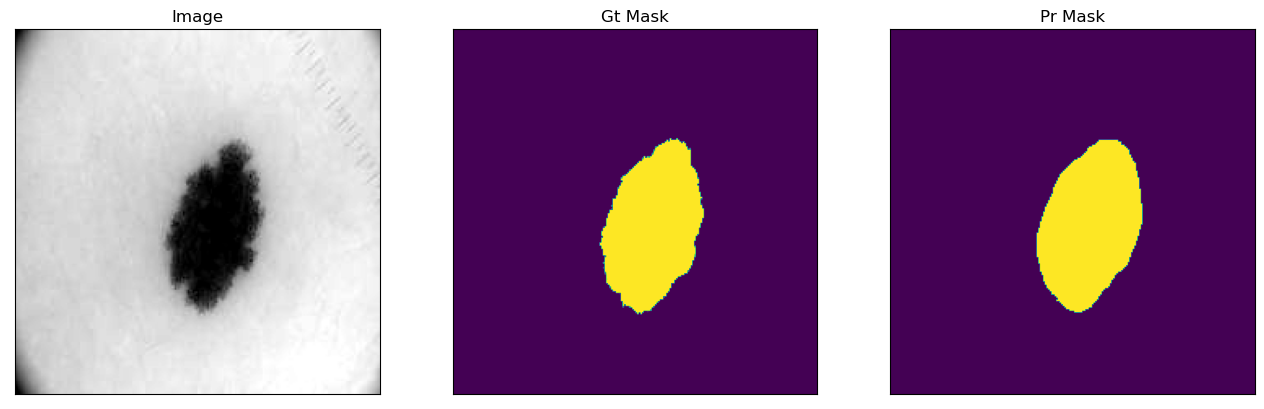

1/1 [==============================] - 0s 311ms/step


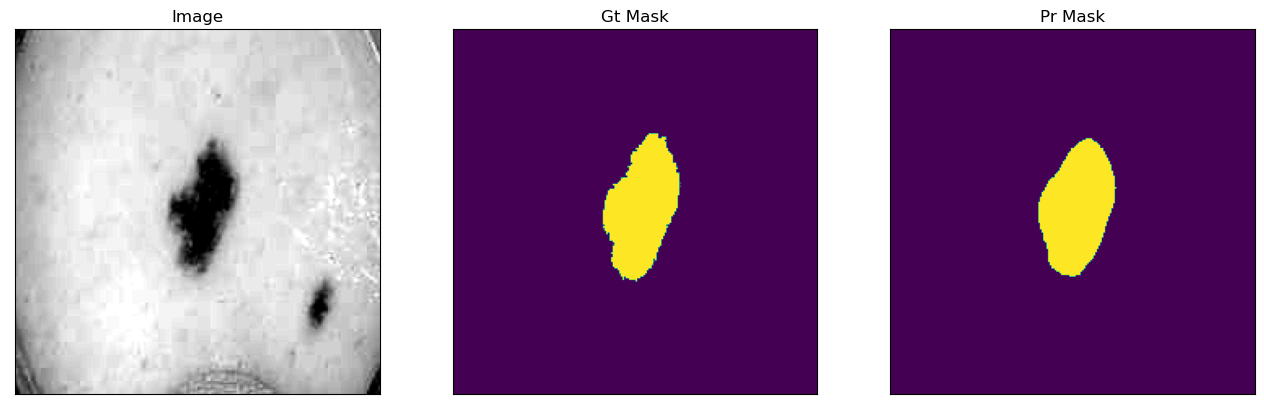

1/1 [==============================] - 0s 314ms/step


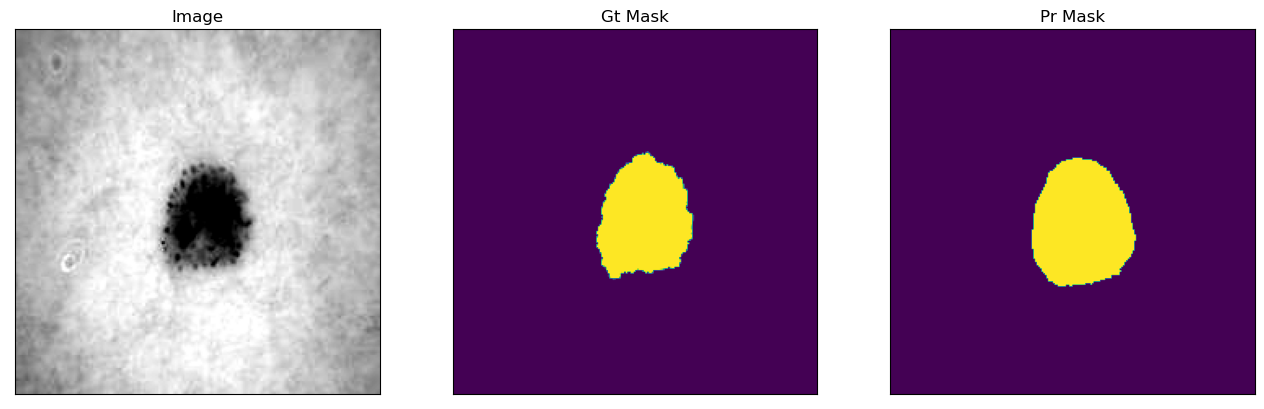

1/1 [==============================] - 0s 316ms/step


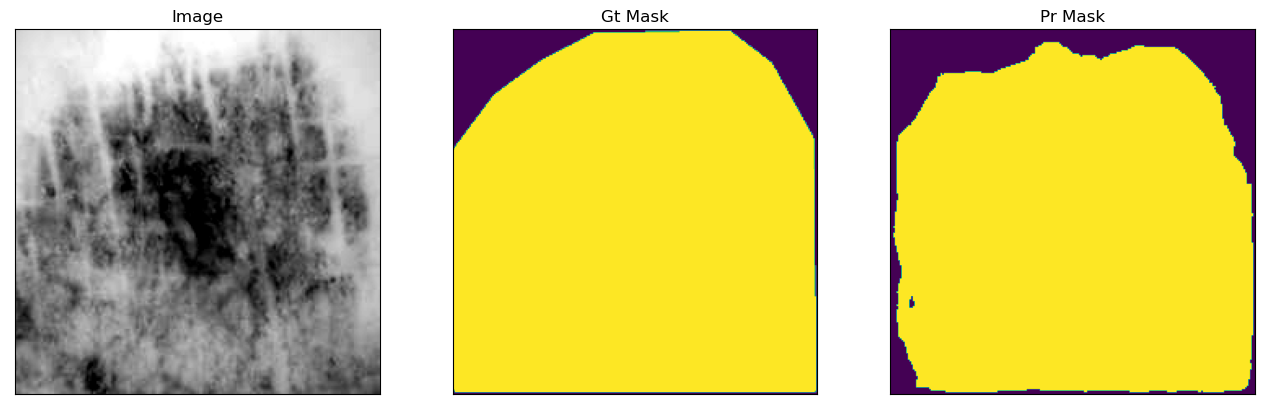

1/1 [==============================] - 0s 317ms/step


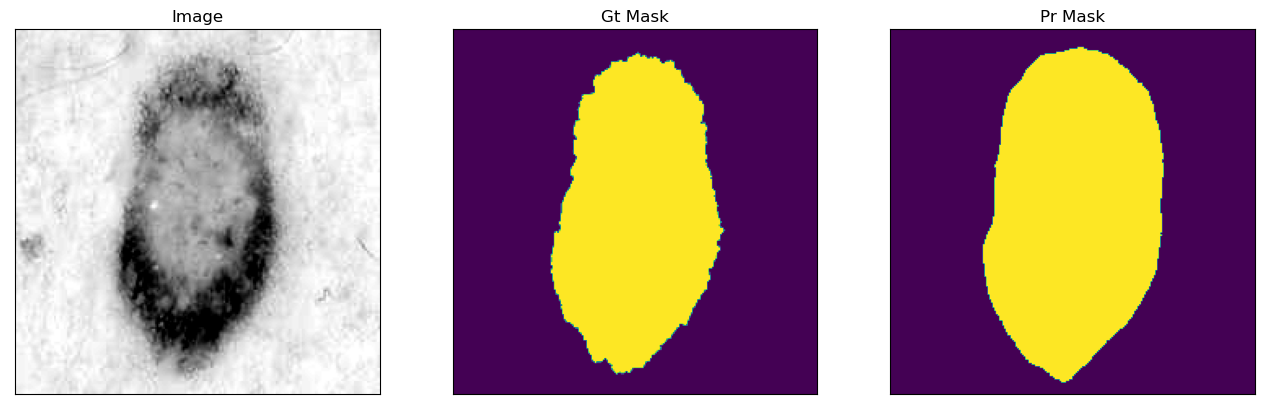

1/1 [==============================] - 0s 315ms/step


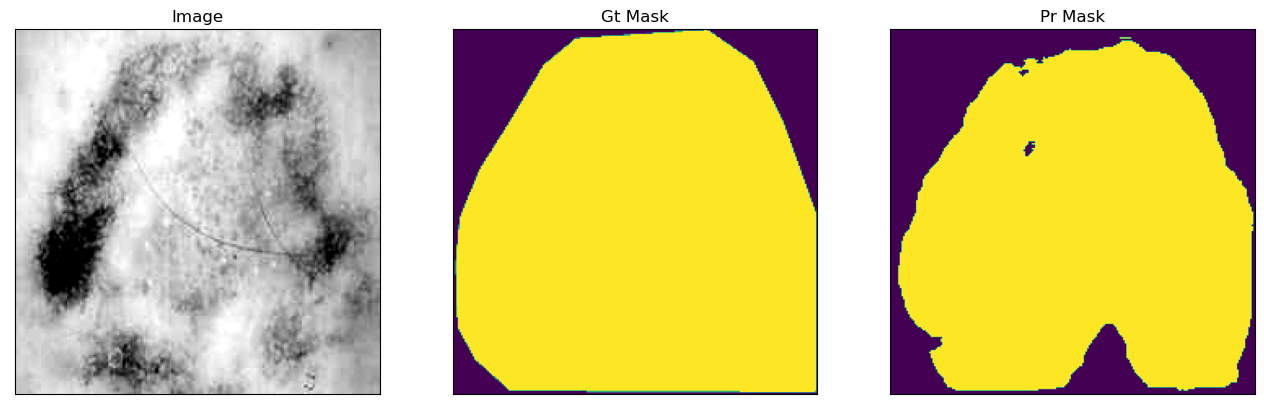

1/1 [==============================] - 0s 312ms/step


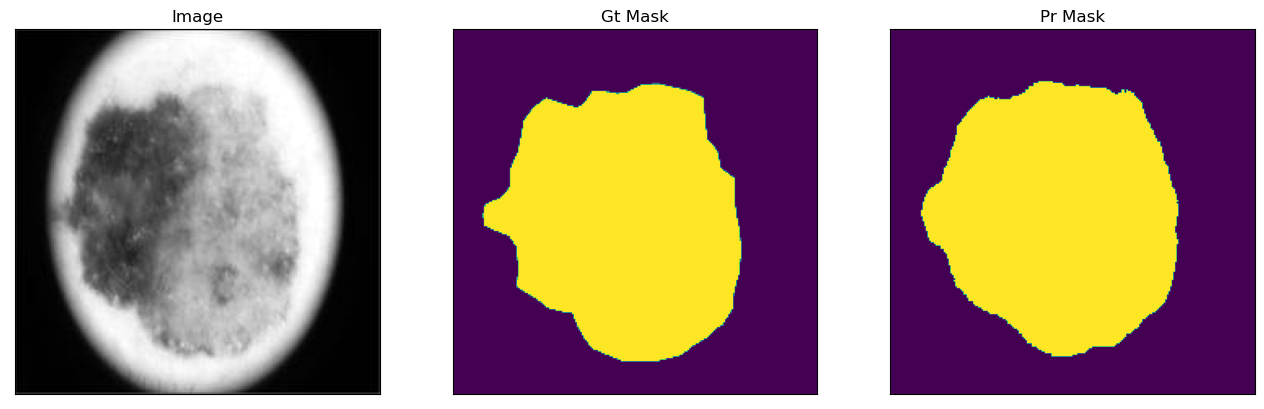

1/1 [==============================] - 0s 323ms/step


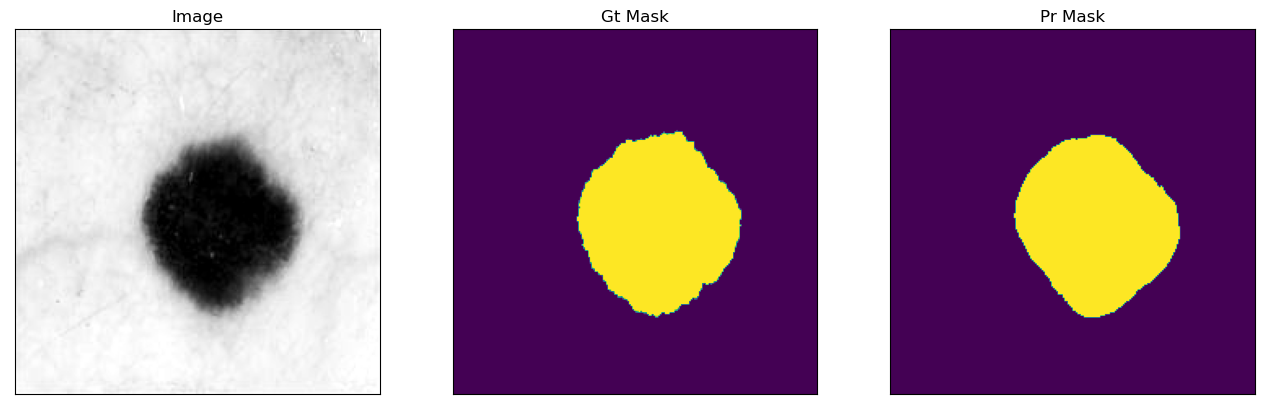

1/1 [==============================] - 0s 312ms/step


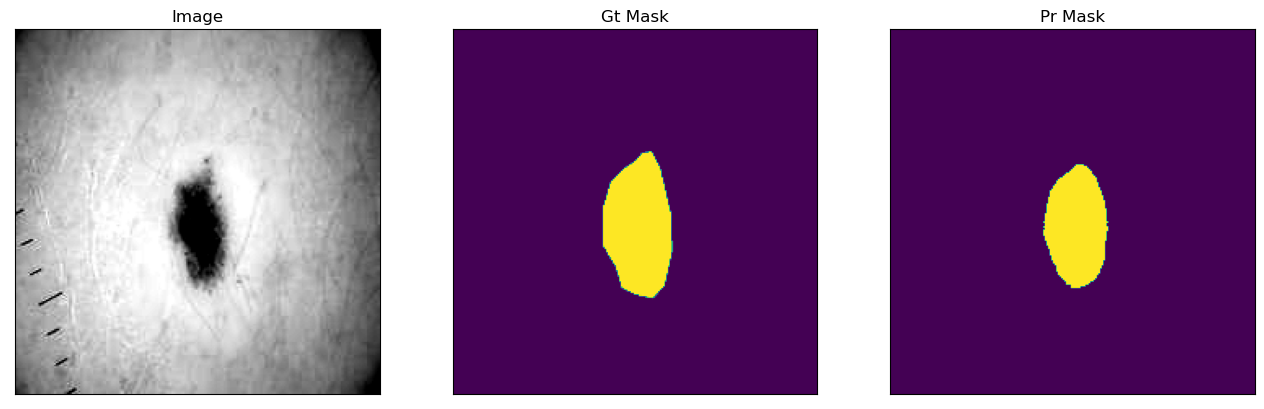

1/1 [==============================] - 0s 317ms/step


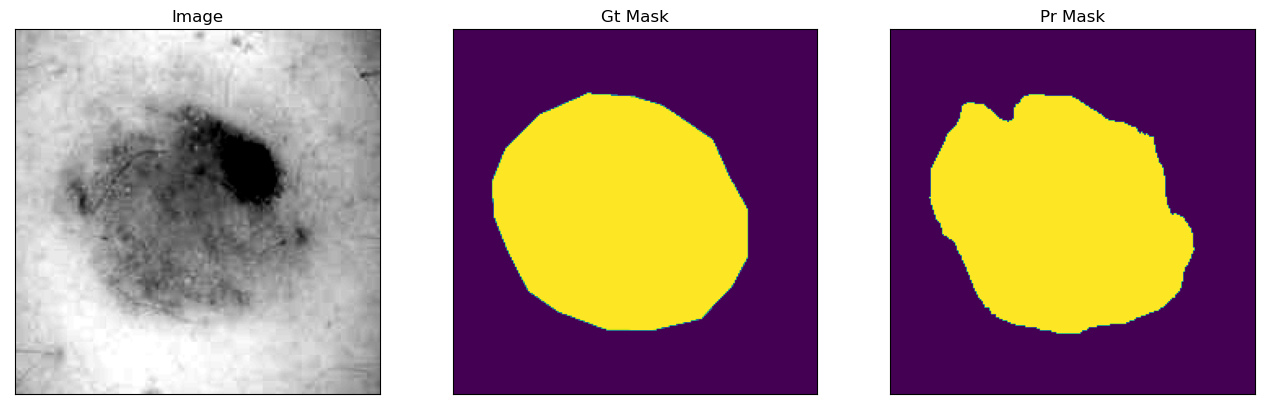

1/1 [==============================] - 0s 312ms/step


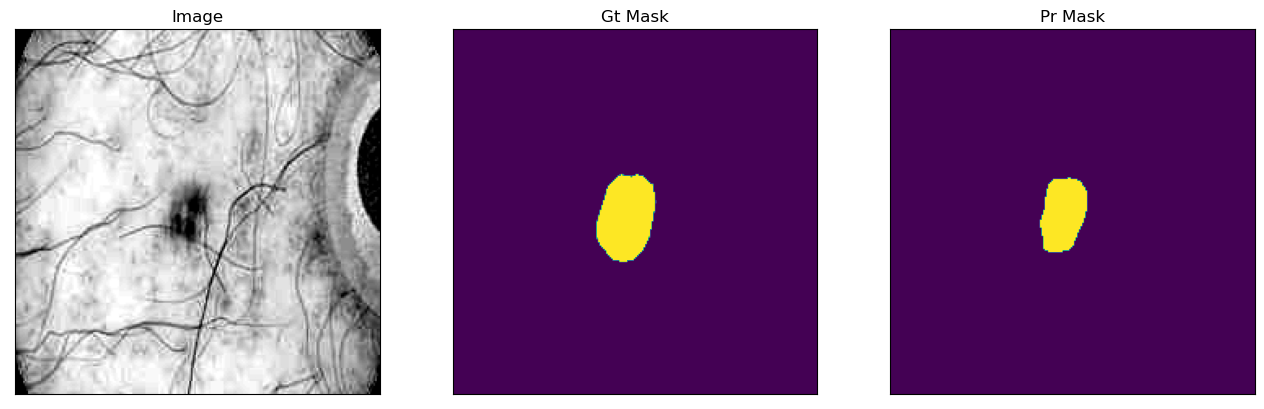

1/1 [==============================] - 0s 422ms/step


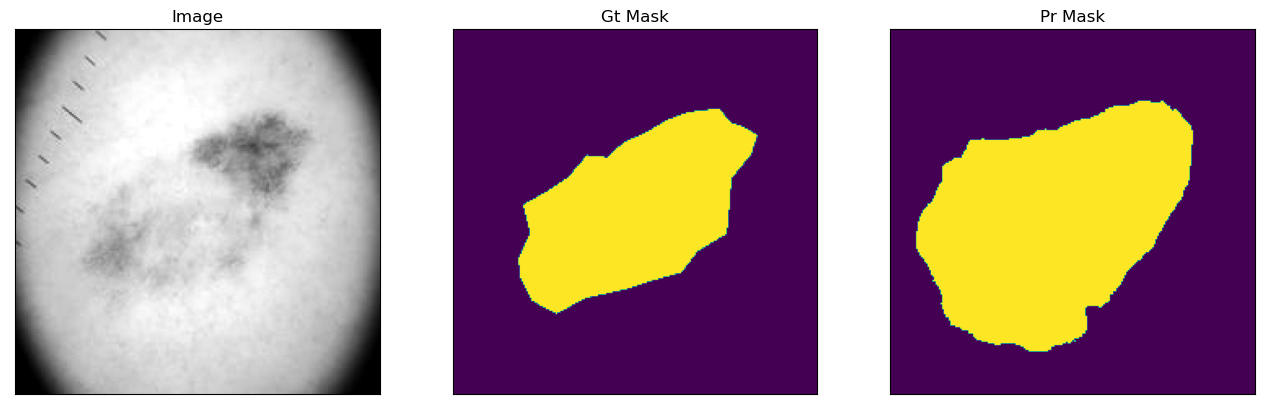

1/1 [==============================] - 0s 314ms/step


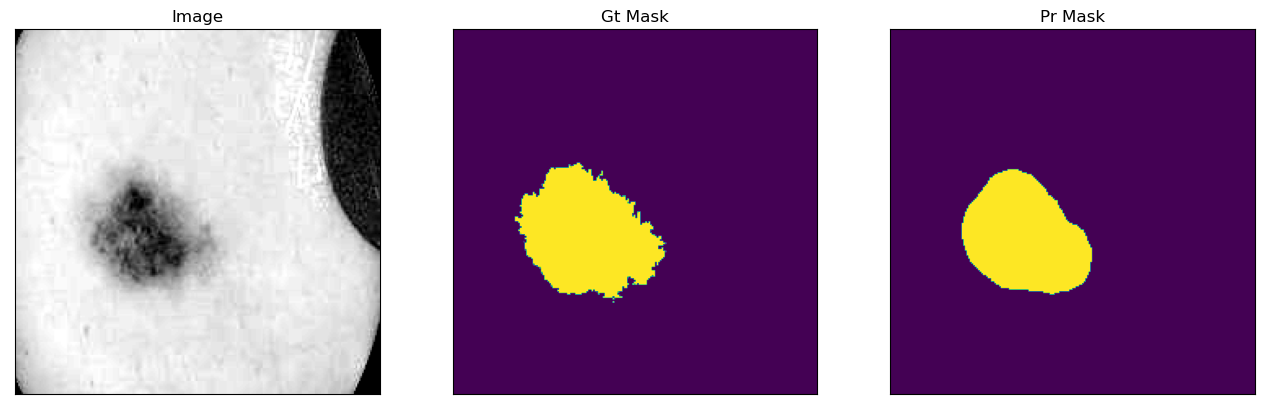

1/1 [==============================] - 0s 314ms/step


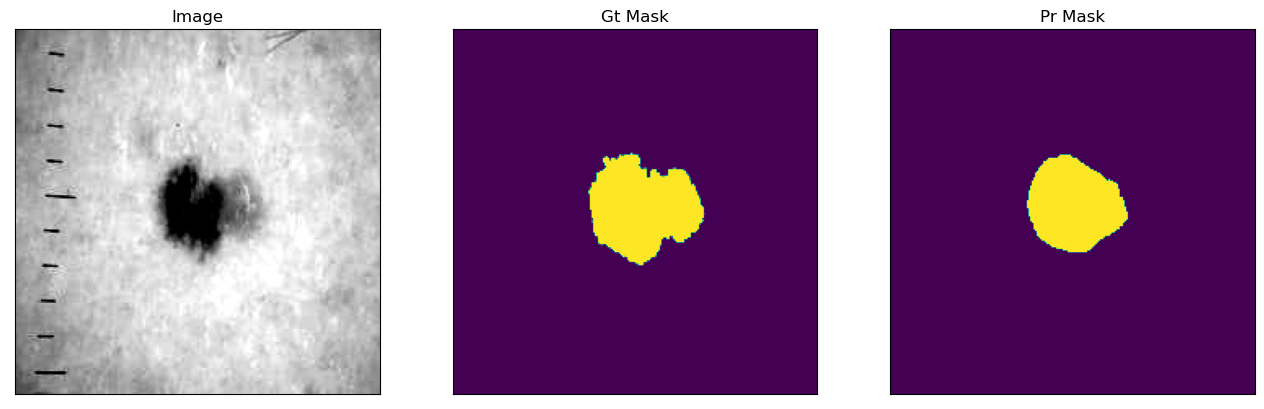

1/1 [==============================] - 0s 317ms/step


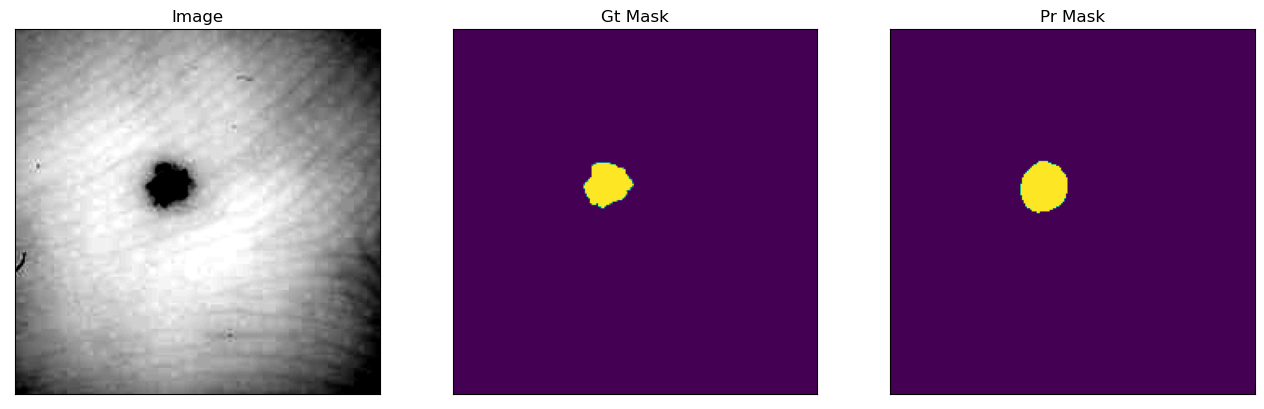

1/1 [==============================] - 0s 314ms/step


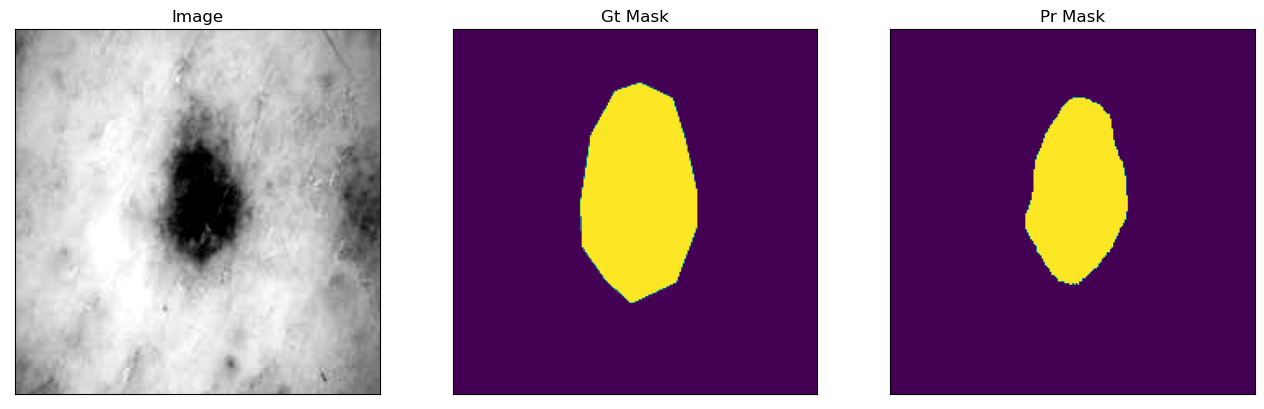

1/1 [==============================] - 0s 312ms/step


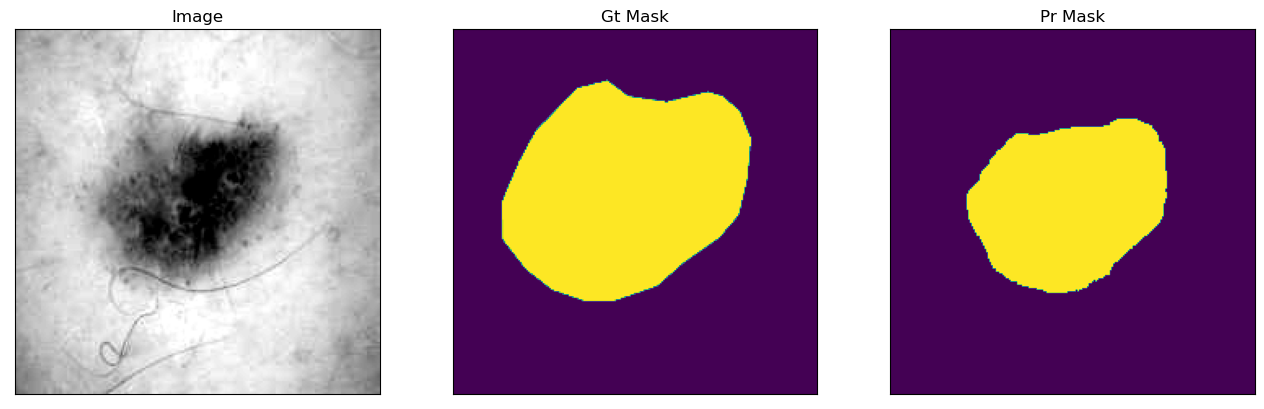

1/1 [==============================] - 0s 311ms/step


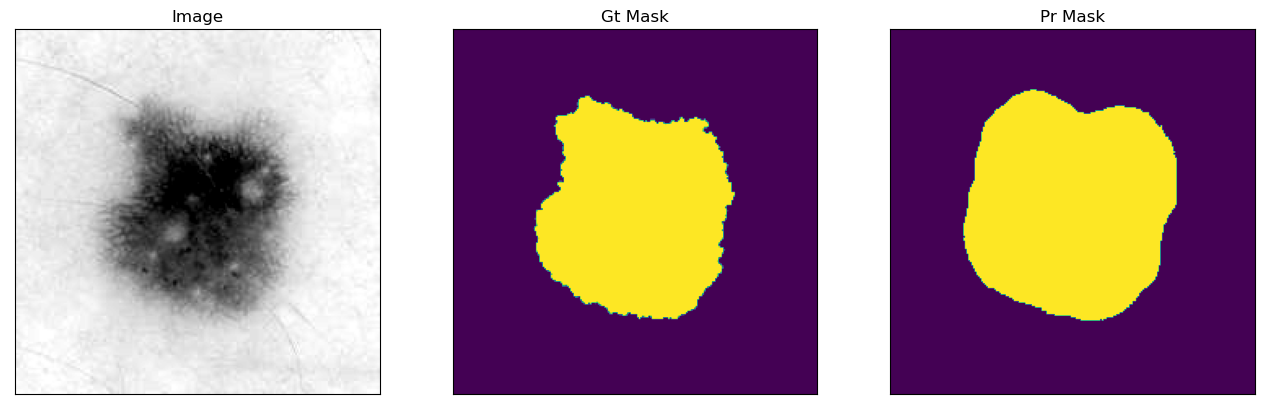

1/1 [==============================] - 0s 304ms/step


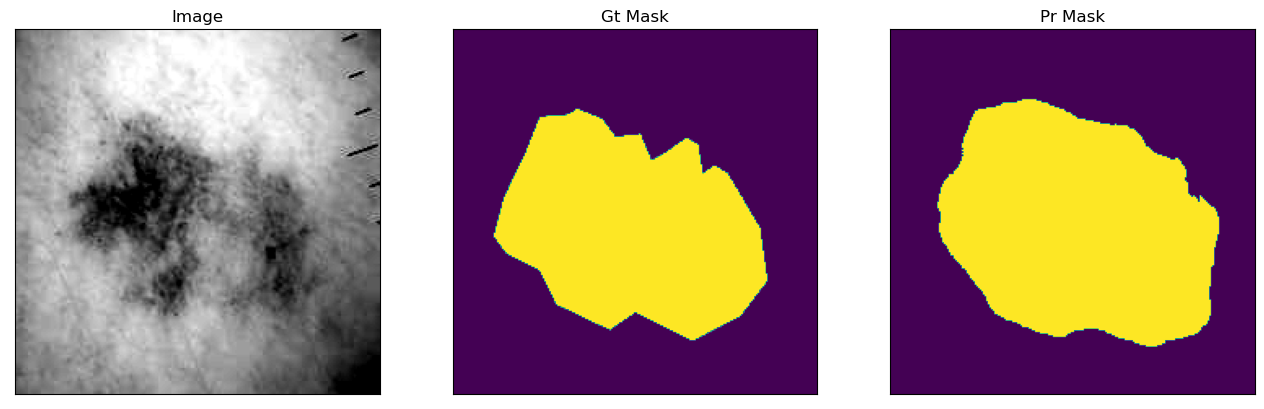

1/1 [==============================] - 0s 306ms/step


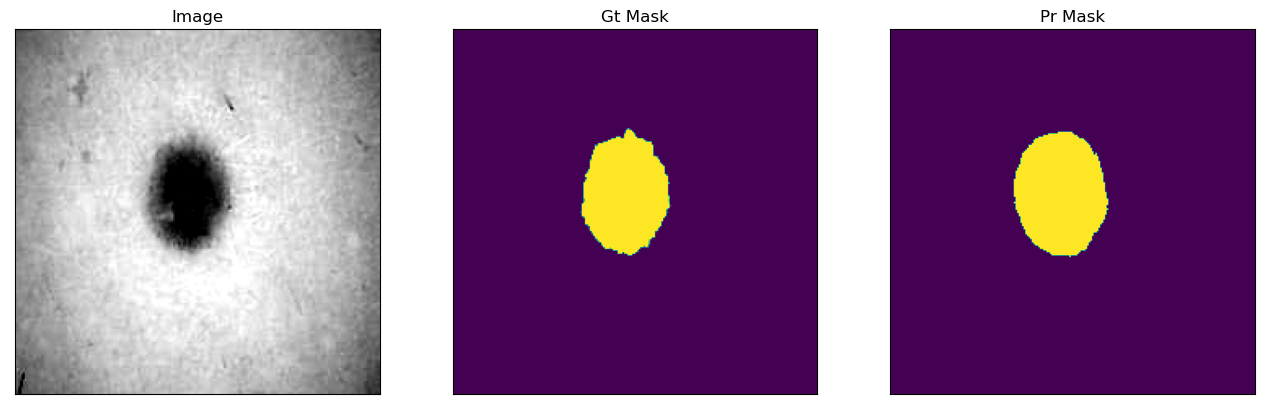

In [11]:
ct = 20
for batch in validation_dataset:
    image, gt_mask = batch
    image = image.numpy()
    gt_mask = gt_mask.numpy()
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
    ct -= 1
    if ct == 0:
        break